# Modeling

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.combine import SMOTEENN
from sklearn.ensemble import AdaBoostClassifier

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.combine import SMOTEENN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# Load data
train = pd.read_csv('feat_train.csv')
test = pd.read_csv('feat_test.csv')
spray = pd.read_csv('feat_spray.csv')

#### Balance Classes

Since our target variable only makes up for 5% of the data, we will need to artificially balance the classes so that our models perform better. We want to use a combination of under and over sampling, so we will use the SMOTE method to accomplish this. 

In [5]:
# Define X and y
X = train.drop('WnvPresent', axis = 1)
y = train['WnvPresent']

In [6]:
# Convert Year and Month to Dummies
X = pd.get_dummies(X, columns = ['Year','Month'])

In [7]:
# Use SMOTE method to balance classes
sme = SMOTEENN()
X_res, y_res = sme.fit_sample(X, y)

In [8]:
# Check class balance 
pd.Series(y_res).value_counts(normalize = True)

1    0.506934
0    0.493066
dtype: float64

With the balanced data, the baseline accuracy score to beat is 50%

#### Logistic Regression

In [19]:
# Train test split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [20]:
# Fit model and accuracy score
logreg = LogisticRegression()
model_logreg = logreg.fit(X_train, y_train)
model_logreg.score(X_train, y_train), model_logreg.score(X_test, y_test)

(0.8232287804389218, 0.806131650135257)

In [21]:
# Evaluate model with AUC-ROC score
y_score = model_logreg.predict(X_test)
metrics.roc_auc_score(y_test, y_score)

0.8062692702980472

In [22]:
# Gridsearch on logistic regression model above
lr_params = {'penalty':['l1', 'l2'], 
             'C': [0.2, 0.3, 0.35, 0.5]}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.8220262551357852, {'C': 0.35, 'penalty': 'l1'})

In [23]:
# Gridsearch test accuracy score
gs.score(X_test, y_test)

0.8058310790501954

In [24]:
# Evaluate gridsearched model with AUC-ROC score
y_score = gs.predict(X_test)
metrics.roc_auc_score(y_test, y_score)

0.80597113629169

Gridsearching did not seem to improve the AUC-ROC score. Neither model was overfit. 

In [25]:
# Determine top predictors in model 
coefs = pd.DataFrame(model_logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
Month_8,2.280485
Year_2013,2.128367
Month_9,1.588101
Tavg,1.480107
Day,1.446884


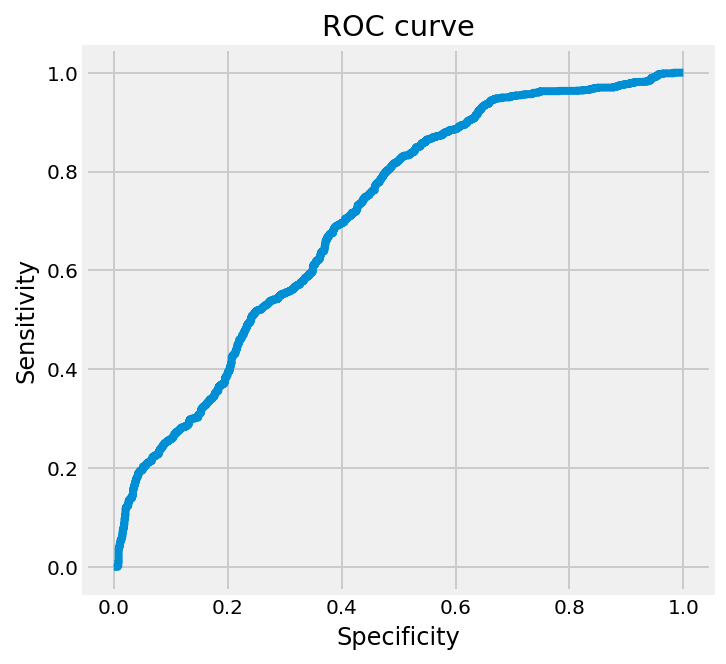

In [29]:
# ROC Plot 
y_probs = model_logreg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');

#### CNN

In [31]:
# Train test split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [32]:
# Reshape our NumPy array 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert dtype from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [33]:
# Preprocess Y data
y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y_test, 2 )

In [34]:
# Define Model Architecture
model = Sequential()
model.add(Convolution1D(filters=10, kernel_size=3, activation="relu", input_shape = (25,1)))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Convolution1D(filters=20, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Convolution1D(filters=30, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(25, activation = 'relu')) 
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'sigmoid'))

# Compile
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
# Fit model with training data
model.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose = 1)

Epoch 1/50
9979/9979 [==============================] - 1s 127us/step - loss: 0.5002 - acc: 0.7441
Epoch 2/50
9979/9979 [==============================] - 1s 86us/step - loss: 0.3588 - acc: 0.8513
Epoch 3/50
9979/9979 [==============================] - 1s 97us/step - loss: 0.3098 - acc: 0.8774
Epoch 4/50
9979/9979 [==============================] - 1s 93us/step - loss: 0.2809 - acc: 0.8893
Epoch 5/50
9979/9979 [==============================] - 1s 96us/step - loss: 0.2532 - acc: 0.9062
Epoch 6/50
9979/9979 [==============================] - 1s 85us/step - loss: 0.2426 - acc: 0.9073
Epoch 7/50
9979/9979 [==============================] - 1s 81us/step - loss: 0.2266 - acc: 0.9141
Epoch 8/50
9979/9979 [==============================] - 1s 80us/step - loss: 0.2158 - acc: 0.9205
Epoch 9/50
9979/9979 [==============================] - 1s 81us/step - loss: 0.2135 - acc: 0.9170
Epoch 10/50
9979/9979 [==============================] - 1s 80us/step - loss: 0.2039 - acc: 0.9219
Epoch 11/50
9979/9

In [36]:
# CNN model summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 10)            40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 20)             620       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 20)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 30)             1830      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 30)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30)             0         
__________

In [37]:
# Score model on test data
score = model.evaluate(X_test, Y_test, verbose = 1)
labels = model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

3327/3327 [==============================] - 0s 62us/step
loss: 0.13321888790448255
acc: 0.955214908325819


In [38]:
# Evaluate model with AUC-ROC score
y_score = model.predict(X_test)
metrics.roc_auc_score(Y_test, y_score)

0.9897758104547103

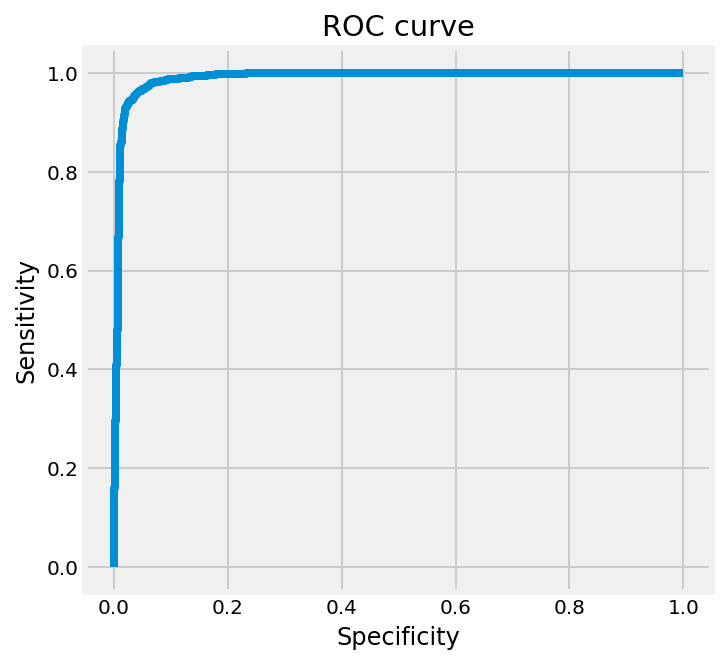

In [39]:
# AUC - ROC Plot 
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');

#### Decision Tree Classifier

In [9]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [11]:
# Gridsearch for optimal parameters
params = {
    'max_depth': [None, 2,3],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf':[1,2,3],
    'max_features':[None, 'sqrt', 'log2']
}

gs_dtc = GridSearchCV(DecisionTreeClassifier(),params)
gs_dtc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 2, 3], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# Check out scores
print(gs_dtc.best_score_, gs_dtc.score(X_test, y_test), gs_dtc.best_params_)

0.9721139430284857 0.979916067146283 {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [13]:
# RoC score
y_hat = gs_dtc.predict(X_test)

metrics.roc_auc_score(y_test, y_hat)

0.9799051688443136

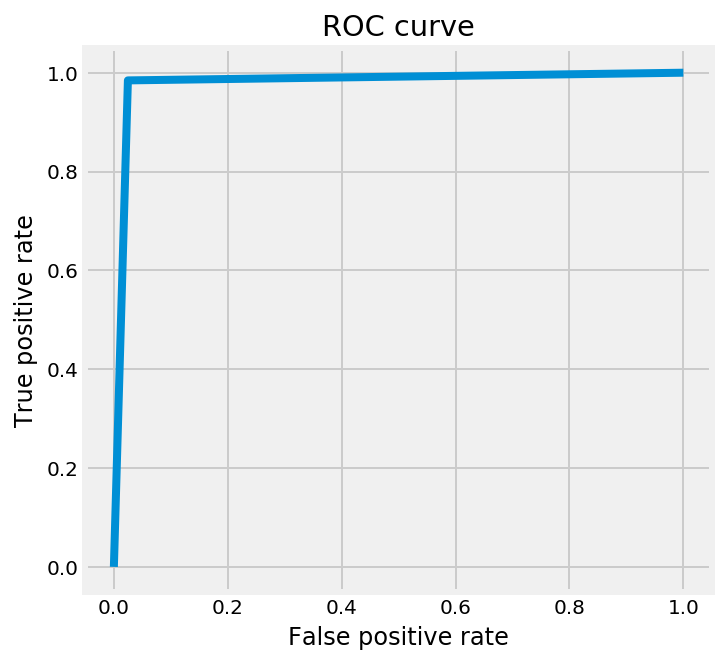

In [14]:
# RoC Plot
y_probs = gs_dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

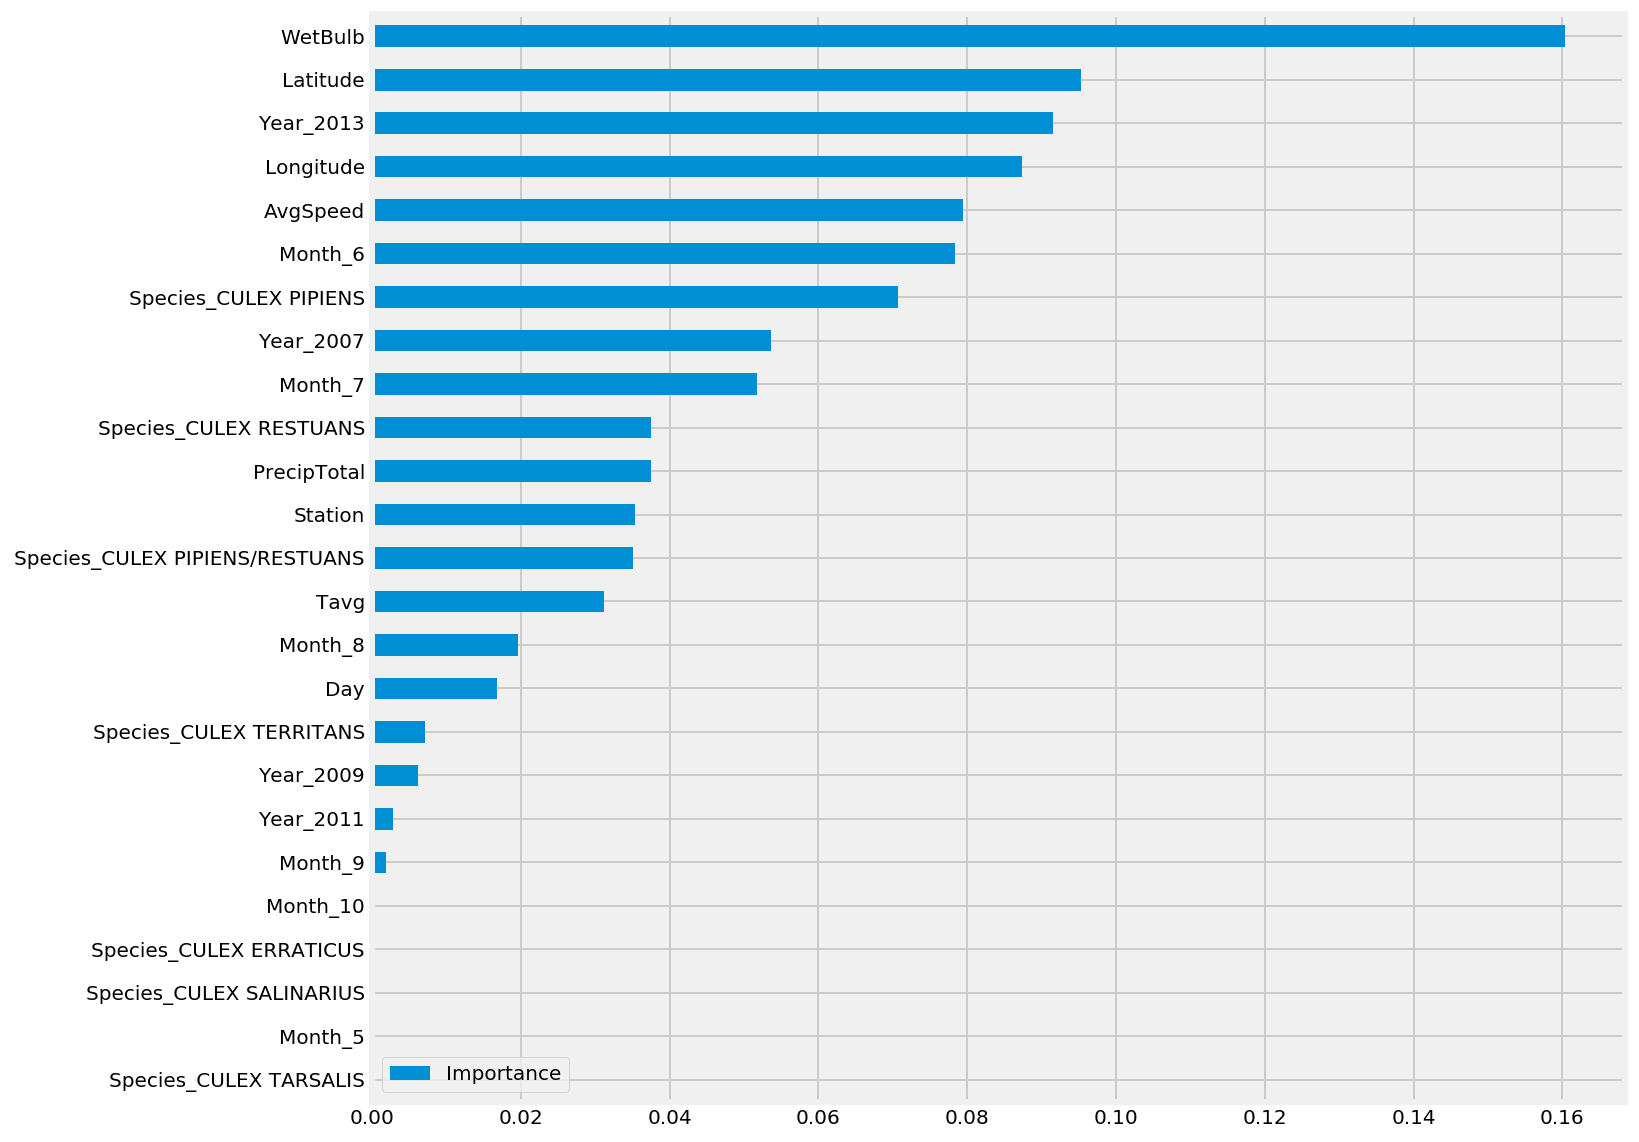

In [16]:
# Important coefs
coefs = pd.DataFrame(gs_dtc.best_estimator_.feature_importances_, index = X.columns, columns = ['Importance'])

axes = coefs.sort_values(by='Importance').plot(kind='barh',figsize = (10,10))

#### Support Vector Classifier

In [17]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [18]:
# Standardize our data for support vector analysis
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [20]:
# fit an untuned model
sv = SVC(probability=True, C=1.0)
sv.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
# Check accuracy on training data
sv.score(X_train, y_train)

0.8981509245377312

In [22]:
# Check accuracy on test data
sv.score(X_test, y_test)

0.8980815347721822

Looks like we didn't overfit.

In [23]:
# Make predictions and check RoC score
y_hat = sv.predict(X_test)

metrics.roc_auc_score(y_test, y_hat)

0.8977332039253748

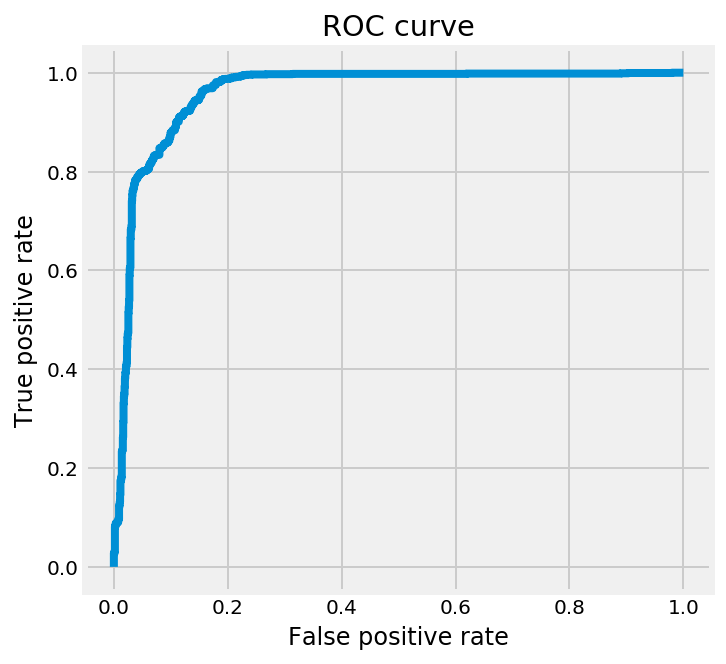

In [24]:
# RoC Plot
y_probs = sv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [25]:
# GridSearch for optimal kernel and C value

params = {
    'C' : [.5, 1.0, 1.5],
    'kernel' : ['rbf', 'linear','sigmoid' ]
}
gs_sv = GridSearchCV(SVC(probability=True), params)
gs_sv.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1.0, 1.5], 'kernel': ['rbf', 'linear', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
# Look at scores
print(gs_sv.best_score_, gs_sv.score(X_test_sc, y_test), gs_sv.best_params_)

0.9355322338830585 0.9523381294964028 {'C': 1.5, 'kernel': 'rbf'}


In [27]:
# Check out RoC score
y_hat = gs_sv.predict(X_test_sc)
metrics.roc_auc_score(y_test,y_hat)

0.9520575865415722

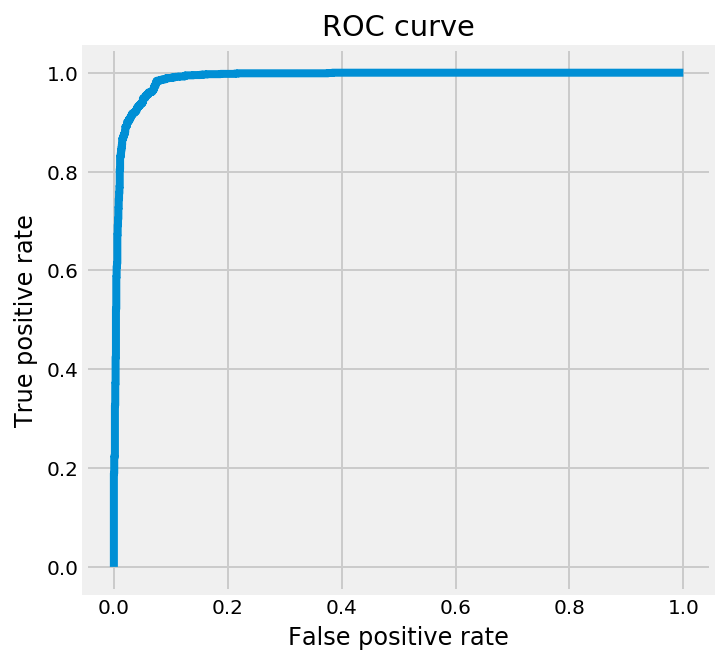

In [28]:
# RoC Plot
y_probs = gs_sv.predict_proba(X_test_sc)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

The grid-searched SVC has a better RoC score.

#### Adaboost (Decision Tree Classifier)

In [29]:
# Adaboost a decision tree classifier
ada_dtc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
ada_dtc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [30]:
# Check RoC score
y_hat = ada_dtc.predict(X_test)
print(metrics.roc_auc_score(y_test, y_hat))

0.9775315431899062


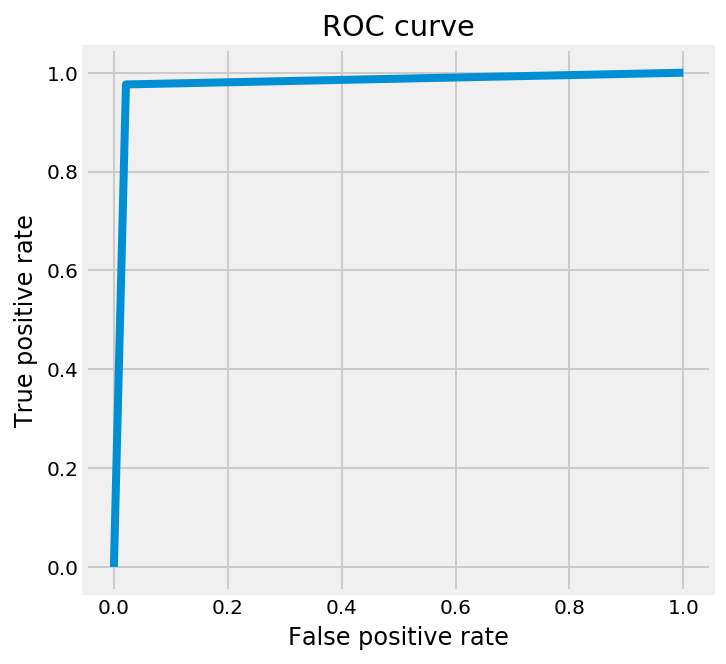

In [31]:
# Plot RoC curve
y_probs = ada_dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');